# Synthetic Face Generation And Classification using WGAN-GP and CNN

# Part 1 : Data Preparation

In [2]:
!pip install opendatasets --quiet

import opendatasets as od

In [ ]:
od.download_kaggle_dataset('https://www.kaggle.com/datasets/jessicali9530/celeba-dataset?select=img_align_celeba','/content/data')

In [4]:
!ls /content/data/celeba-dataset/img_align_celeba/img_align_celeba

000001.jpg  033768.jpg	067535.jpg  101302.jpg	135069.jpg  168836.jpg
000002.jpg  033769.jpg	067536.jpg  101303.jpg	135070.jpg  168837.jpg
000003.jpg  033770.jpg	067537.jpg  101304.jpg	135071.jpg  168838.jpg
000004.jpg  033771.jpg	067538.jpg  101305.jpg	135072.jpg  168839.jpg
000005.jpg  033772.jpg	067539.jpg  101306.jpg	135073.jpg  168840.jpg
000006.jpg  033773.jpg	067540.jpg  101307.jpg	135074.jpg  168841.jpg
000007.jpg  033774.jpg	067541.jpg  101308.jpg	135075.jpg  168842.jpg
000008.jpg  033775.jpg	067542.jpg  101309.jpg	135076.jpg  168843.jpg
000009.jpg  033776.jpg	067543.jpg  101310.jpg	135077.jpg  168844.jpg
000010.jpg  033777.jpg	067544.jpg  101311.jpg	135078.jpg  168845.jpg
000011.jpg  033778.jpg	067545.jpg  101312.jpg	135079.jpg  168846.jpg
000012.jpg  033779.jpg	067546.jpg  101313.jpg	135080.jpg  168847.jpg
000013.jpg  033780.jpg	067547.jpg  101314.jpg	135081.jpg  168848.jpg
000014.jpg  033781.jpg	067548.jpg  101315.jpg	135082.jpg  168849.jpg
000015.jpg  033782.jpg	067549.jpg 

In [5]:
!ls /content/data/celeba-dataset

img_align_celeba      list_bbox_celeba.csv     list_landmarks_align_celeba.csv
list_attr_celeba.csv  list_eval_partition.csv


In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from scipy import linalg
from torchvision.models import inception_v3
from torch.autograd import Variable
import gc

In [8]:
class CustomCelebADataset(Dataset):
    def __init__(self, img_dir, attr_file, partition_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        self.attr_df = pd.read_csv(attr_file)
        self.partition_df = pd.read_csv(partition_file)

        self.data = pd.merge(self.attr_df, self.partition_df, on="image_id")

        self.data['Young'] = self.data['Young'].replace(-1, 0)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]['image_id']
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        label = self.data.iloc[idx]['Young']
        partition = self.data.iloc[idx]['partition']

        if self.transform:
            image = self.transform(image)

        return image, label, partition

In [9]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

img_dir = '/content/data/celeba-dataset/img_align_celeba/img_align_celeba'
attr_file = '/content/data/celeba-dataset/list_attr_celeba.csv'
partition_file = '/content/data/celeba-dataset/list_eval_partition.csv'

In [10]:
dataset = CustomCelebADataset(img_dir=img_dir, attr_file=attr_file, partition_file=partition_file, transform=transform)

In [11]:
train_indices = []
test_indices = []
val_indices = []

for i in range(len(dataset)):
    if dataset[i][2] == 0:
        train_indices.append(i)
    elif dataset[i][2] == 1:
        val_indices.append(i)
    else:
        test_indices.append(i)

In [14]:
total_orig = len(train_indices) + len(val_indices) + len(test_indices)
train_prop = len(train_indices) / total_orig
val_prop = len(val_indices) / total_orig
test_prop = len(test_indices) / total_orig

In [15]:
target_total = 30000
target_train = int(target_total * train_prop)
target_val = int(target_total * val_prop)
target_test = target_total - target_train - target_val

In [16]:
import random
random.seed(42)
train_indices = random.sample(train_indices, target_train)
val_indices = random.sample(val_indices, target_val)
test_indices = random.sample(test_indices, target_test)

In [17]:
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

In [18]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
print(f"Training set size: {len(train_dataset)}, Validation set size: {len(val_dataset)}, Test set size: {len(test_dataset)}")
print(f"Total sampled images: {len(train_dataset) + len(val_dataset) + len(test_dataset)}")

Training set size: 24102, Validation set size: 2941, Test set size: 2957
Total sampled images: 30000


In [20]:
def imshow(img, title=None):
    img = img / 2 + 0.5
    npimg = img.numpy()
    
    plt.figure(figsize=(4, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

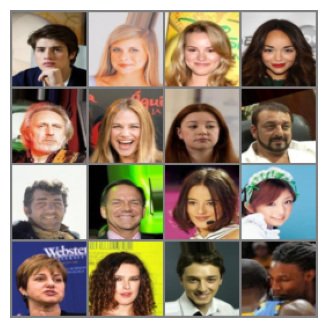

In [21]:
dataiter = iter(train_loader)
images, labels, _ = next(dataiter)

imshow(torchvision.utils.make_grid(images[:16], nrow=4, padding=2))

# Part 2: WGAN Implementation for Synthetic Data Generation

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

In [24]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False)
        )

    def forward(self, img):
        return self.model(img)

In [25]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(torch.ones_like(d_interpolates), requires_grad=False)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [26]:
latent_dim = 100
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

lr = 0.0001
beta1 = 0.0
beta2 = 0.9
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

n_epochs = 30
n_critic = 5
lambda_gp = 10
batch_size = 128

In [35]:
g_losses = []
d_losses = []

for epoch in range(n_epochs):
    for i, (real_imgs, _, _) in enumerate(train_loader):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        for _ in range(n_critic):
            optimizer_D.zero_grad()
            z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake_imgs = generator(z)
            real_validity = discriminator(real_imgs)
            fake_validity = discriminator(fake_imgs)
            gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty
            d_loss.backward()
            optimizer_D.step()

        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        gen_imgs = generator(z)
        g_loss = -torch.mean(discriminator(gen_imgs))
        g_loss.backward()
        optimizer_G.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

        if i % 100 == 0:
            print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(train_loader)}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

[Epoch 0/30] [Batch 0/189] [D loss: 8.5394] [G loss: 1.0307]
[Epoch 0/30] [Batch 100/189] [D loss: -25.2826] [G loss: 6.8794]
[Epoch 1/30] [Batch 0/189] [D loss: -21.8028] [G loss: 10.5841]
[Epoch 1/30] [Batch 100/189] [D loss: -17.8819] [G loss: -7.6528]
[Epoch 2/30] [Batch 0/189] [D loss: -15.0876] [G loss: 18.2830]
[Epoch 2/30] [Batch 100/189] [D loss: -14.0055] [G loss: 17.1831]
[Epoch 3/30] [Batch 0/189] [D loss: -12.6068] [G loss: 4.8938]
[Epoch 3/30] [Batch 100/189] [D loss: -11.7889] [G loss: -14.2443]
[Epoch 4/30] [Batch 0/189] [D loss: -10.7467] [G loss: 6.4766]
[Epoch 4/30] [Batch 100/189] [D loss: -15.7958] [G loss: -8.0937]
[Epoch 5/30] [Batch 0/189] [D loss: -10.7370] [G loss: 13.6714]
[Epoch 5/30] [Batch 100/189] [D loss: -11.5416] [G loss: -3.2837]
[Epoch 6/30] [Batch 0/189] [D loss: -9.0426] [G loss: 14.6300]
[Epoch 6/30] [Batch 100/189] [D loss: -10.1491] [G loss: 21.2327]
[Epoch 7/30] [Batch 0/189] [D loss: -9.6606] [G loss: 15.0160]
[Epoch 7/30] [Batch 100/189] [D l

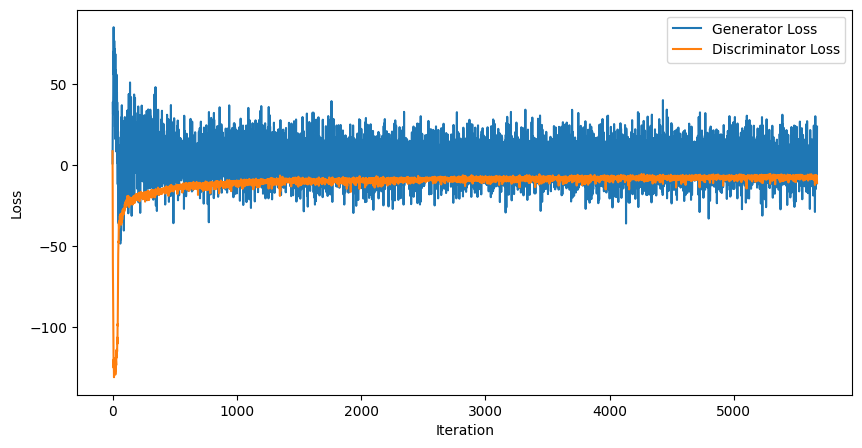

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

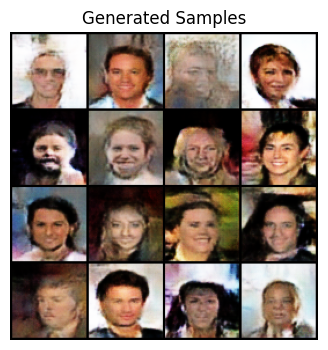

In [52]:
def show_generated_images(gen_imgs, nrow=4, figsize=(4, 4), title=None):
    grid = torchvision.utils.make_grid(gen_imgs, nrow=nrow, normalize=True, padding=2)
    npimg = grid.permute(1, 2, 0).numpy()

    plt.figure(figsize=figsize)
    plt.imshow(npimg)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

with torch.no_grad():
    z = torch.randn(16, latent_dim, 1, 1, device=device)
    gen_imgs = generator(z).cpu()
    show_generated_images(gen_imgs, title="Generated Samples")

In [27]:
inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
inception_model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 91.9MB/s] 


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

Fake images shape: torch.Size([2500, 3, 64, 64])
Real images shape: torch.Size([128, 3, 64, 64])


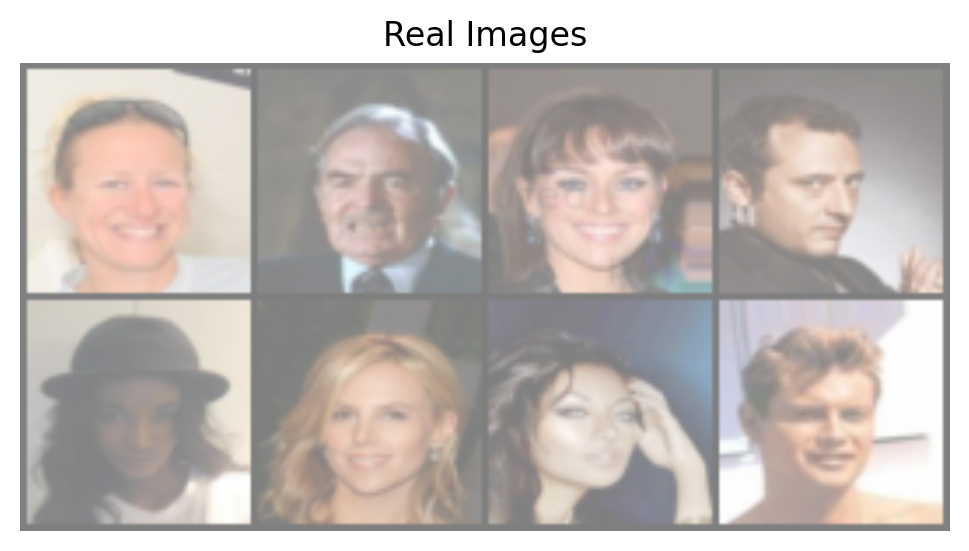

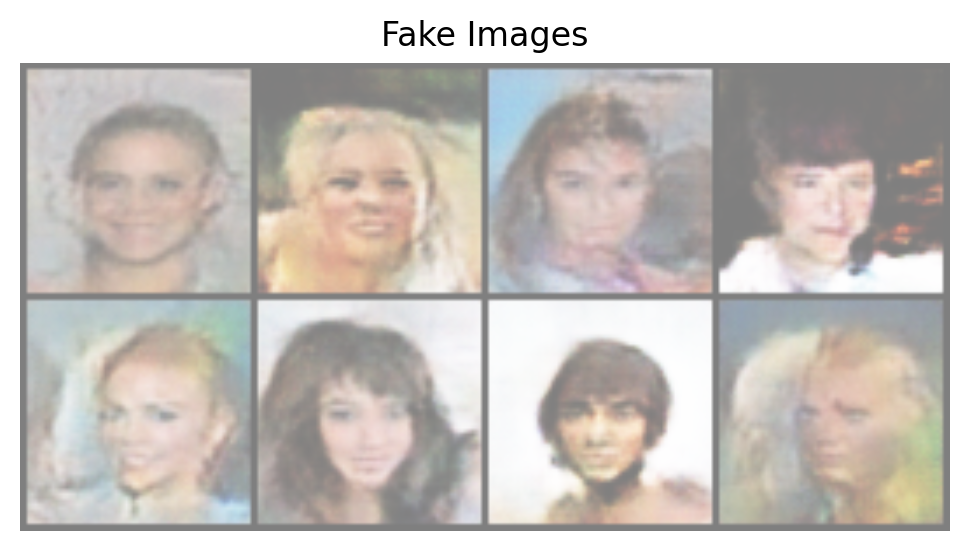

In [55]:
torch.cuda.empty_cache()
gc.collect()

n_eval_samples = 2500
z = torch.randn(n_eval_samples, latent_dim, 1, 1, device=device)
fake_images = generator(z).detach()
print(f"Fake images shape: {fake_images.shape}")

real_images = next(iter(train_loader))[0][:n_eval_samples].to(device)
print(f"Real images shape: {real_images.shape}")

def imshow(img, title=None, figsize=(6, 6), dpi=200):
    img = img / 2 + 0.5
    npimg = img.cpu().numpy()
    
    plt.figure(figsize=figsize, dpi=dpi)
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='bilinear')
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

real_grid = torchvision.utils.make_grid(real_images[:8], nrow=4, normalize=True)
imshow(real_grid, "Real Images")

fake_grid = torchvision.utils.make_grid(fake_images[:8], nrow=4, normalize=True)
imshow(fake_grid, "Fake Images")

if len(fake_images.shape) != 4 or len(real_images.shape) != 4:
    raise ValueError(f"Expected 4D tensors, got fake_images shape {fake_images.shape}, real_images shape {real_images.shape}")

In [28]:
def get_inception_score(images, splits=10):
    batch_size = 32
    preds = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size].to(device)
        batch = torch.nn.functional.interpolate(batch, size=(299, 299), mode='bilinear', align_corners=False)
        with torch.no_grad():
            pred = inception_model(batch).softmax(dim=1)
        preds.append(pred.cpu().numpy())
        torch.cuda.empty_cache()
    preds = np.concatenate(preds, 0)
    scores = []
    for i in range(splits):
        part = preds[(i * preds.shape[0] // splits):((i + 1) * preds.shape[0] // splits), :]
        kl = part * (np.log(part) - np.log(np.mean(part, 0, keepdims=True)))
        kl = np.mean(np.sum(kl, 1))
        scores.append(np.exp(kl))
    return np.mean(scores), np.std(scores)

def compute_fid(real_images, fake_images):
    batch_size = 32
    real_features = []
    fake_features = []

    for i in range(0, len(real_images), batch_size):
        batch = real_images[i:i + batch_size].to(device)
        batch = torch.nn.functional.interpolate(batch, size=(299, 299), mode='bilinear', align_corners=False)
        with torch.no_grad():
            features = inception_model(batch).detach().cpu().numpy()
        real_features.append(features)
        torch.cuda.empty_cache()

    for i in range(0, len(fake_images), batch_size):
        batch = fake_images[i:i + batch_size].to(device)
        batch = torch.nn.functional.interpolate(batch, size=(299, 299), mode='bilinear', align_corners=False)
        with torch.no_grad():
            features = inception_model(batch).detach().cpu().numpy()
        fake_features.append(features)
        torch.cuda.empty_cache()

    real_features = np.concatenate(real_features, axis=0)
    fake_features = np.concatenate(fake_features, axis=0)

    mu1, sigma1 = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = np.mean(fake_features, axis=0), np.cov(fake_features, rowvar=False)
    diff = mu1 - mu2
    covmean = linalg.sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

In [57]:
is_mean, is_std = get_inception_score(fake_images, splits=10)
fid_value = compute_fid(real_images, fake_images)

print(f"Inception Score: {is_mean:.2f} ± {is_std:.2f}")
print(f"FID: {fid_value:.2f}")

Inception Score: 2.74 ± 0.12
FID: 585.03


# Part 3: Hyperparameter Tuning and Optimization

In [29]:
!pip install optuna --quiet

In [32]:
import optuna

def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    latent_dim = trial.suggest_categorical("latent_dim", [64, 100, 128])
    n_critic = trial.suggest_int("n_critic", 3, 10)
    n_epochs = 10
    lambda_gp = 10

    print(f"\nStarting Trial {trial.number} with params: lr={lr:.6f}, batch_size={batch_size}, latent_dim={latent_dim}, n_critic={n_critic}")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    generator = Generator(latent_dim).to(device)
    discriminator = Discriminator().to(device)

    optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.0, 0.9))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.0, 0.9))

    for epoch in range(n_epochs):
        print(f"  Epoch {epoch+1}/{n_epochs}")
        for i, (real_imgs, _, _) in enumerate(train_loader):
            real_imgs = real_imgs.to(device)
            curr_batch_size = real_imgs.size(0)

            for _ in range(n_critic):
                optimizer_D.zero_grad()
                z = torch.randn(curr_batch_size, latent_dim, 1, 1, device=device)
                fake_imgs = generator(z)
                real_validity = discriminator(real_imgs)
                fake_validity = discriminator(fake_imgs)
                gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)
                d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty
                d_loss.backward()
                optimizer_D.step()

            optimizer_G.zero_grad()
            z = torch.randn(curr_batch_size, latent_dim, 1, 1, device=device)
            gen_imgs = generator(z)
            g_loss = -torch.mean(discriminator(gen_imgs))
            g_loss.backward()
            optimizer_G.step()

            if i % 100 == 0:
                print(f"    Batch {i}/{len(train_loader)} - D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")

    print("  Evaluating FID...")
    n_eval_samples = 2500
    z = torch.randn(n_eval_samples, latent_dim, 1, 1, device=device)
    fake_images = generator(z).detach()
    real_images = next(iter(train_loader))[0][:n_eval_samples].to(device)
    fid_value = compute_fid(real_images, fake_images)
    print(f"  Trial {trial.number} FID: {fid_value:.2f}")

    return fid_value

study = optuna.create_study(direction="minimize")
print("Starting Optuna optimization with 5 trials...")
study.optimize(objective, n_trials=5)

print("Best params:", study.best_trial.params)
print("Best value:", study.best_trial.value)

[I 2025-05-01 04:09:18,501] A new study created in memory with name: no-name-c7a62004-a414-4447-a897-2596d5e5e9c4


Starting Optuna optimization with 5 trials...

Starting Trial 0 with params: lr=0.000227, batch_size=128, latent_dim=128, n_critic=8
  Epoch 1/10
    Batch 0/189 - D_loss: -89.2223, G_loss: 63.4305
    Batch 100/189 - D_loss: -27.9564, G_loss: 2.3762
  Epoch 2/10
    Batch 0/189 - D_loss: -25.2318, G_loss: -12.3224
    Batch 100/189 - D_loss: -18.0261, G_loss: -3.1588
  Epoch 3/10
    Batch 0/189 - D_loss: -18.4034, G_loss: -6.8171
    Batch 100/189 - D_loss: -14.7499, G_loss: -16.3511
  Epoch 4/10
    Batch 0/189 - D_loss: -15.9443, G_loss: 3.3365
    Batch 100/189 - D_loss: -14.7832, G_loss: 11.6321
  Epoch 5/10
    Batch 0/189 - D_loss: -15.1846, G_loss: 0.5923
    Batch 100/189 - D_loss: -15.4319, G_loss: -11.0293
  Epoch 6/10
    Batch 0/189 - D_loss: -16.7918, G_loss: -5.9209
    Batch 100/189 - D_loss: -14.0181, G_loss: -3.1594
  Epoch 7/10
    Batch 0/189 - D_loss: -12.6312, G_loss: 7.5288
    Batch 100/189 - D_loss: -15.1233, G_loss: 21.5415
  Epoch 8/10
    Batch 0/189 - D_lo

[I 2025-05-01 05:05:28,542] Trial 0 finished with value: 801.2850950116598 and parameters: {'lr': 0.00022729620143304224, 'batch_size': 128, 'latent_dim': 128, 'n_critic': 8}. Best is trial 0 with value: 801.2850950116598.


  Trial 0 FID: 801.29

Starting Trial 1 with params: lr=0.000282, batch_size=32, latent_dim=100, n_critic=8
  Epoch 1/10
    Batch 0/754 - D_loss: -126.6113, G_loss: 66.6990
    Batch 100/754 - D_loss: -32.1224, G_loss: -22.3636
    Batch 200/754 - D_loss: -29.6765, G_loss: 0.7404
    Batch 300/754 - D_loss: -26.0157, G_loss: -5.1755
    Batch 400/754 - D_loss: -30.1036, G_loss: -0.5698
    Batch 500/754 - D_loss: -33.6017, G_loss: -10.9773
    Batch 600/754 - D_loss: -21.7095, G_loss: 16.4418
    Batch 700/754 - D_loss: -21.3386, G_loss: -1.2145
  Epoch 2/10
    Batch 0/754 - D_loss: -21.7645, G_loss: 11.3191
    Batch 100/754 - D_loss: -26.1146, G_loss: -15.3177
    Batch 200/754 - D_loss: -24.4156, G_loss: 4.9687
    Batch 300/754 - D_loss: -17.1755, G_loss: 7.3947
    Batch 400/754 - D_loss: -23.9983, G_loss: -4.2150
    Batch 500/754 - D_loss: -17.4699, G_loss: 9.8392
    Batch 600/754 - D_loss: -19.2871, G_loss: -6.0903
    Batch 700/754 - D_loss: -23.4813, G_loss: 2.7923
  Epoch

[I 2025-05-01 06:00:00,800] Trial 1 finished with value: 1071.8543688610553 and parameters: {'lr': 0.0002818722591811242, 'batch_size': 32, 'latent_dim': 100, 'n_critic': 8}. Best is trial 0 with value: 801.2850950116598.


  Trial 1 FID: 1071.85

Starting Trial 2 with params: lr=0.000032, batch_size=32, latent_dim=128, n_critic=4
  Epoch 1/10
    Batch 0/754 - D_loss: 9.6073, G_loss: 0.0804
    Batch 100/754 - D_loss: -102.1291, G_loss: 15.7686
    Batch 200/754 - D_loss: -87.3521, G_loss: -11.5126
    Batch 300/754 - D_loss: -23.4962, G_loss: -37.4244
    Batch 400/754 - D_loss: -19.4913, G_loss: 10.6289
    Batch 500/754 - D_loss: -16.4654, G_loss: 9.2482
    Batch 600/754 - D_loss: -16.1121, G_loss: -14.9022
    Batch 700/754 - D_loss: -15.0334, G_loss: 38.5360
  Epoch 2/10
    Batch 0/754 - D_loss: -16.9841, G_loss: -3.6982
    Batch 100/754 - D_loss: -12.0390, G_loss: -0.9275
    Batch 200/754 - D_loss: -5.6985, G_loss: -32.4750
    Batch 300/754 - D_loss: -7.4381, G_loss: -7.1590
    Batch 400/754 - D_loss: -12.6254, G_loss: 25.0472
    Batch 500/754 - D_loss: -8.6400, G_loss: 20.8887
    Batch 600/754 - D_loss: -9.3245, G_loss: -1.8870
    Batch 700/754 - D_loss: -10.5262, G_loss: 1.6192
  Epoch 3

[I 2025-05-01 06:28:56,671] Trial 2 finished with value: 1433.7032802364004 and parameters: {'lr': 3.2150009733669487e-05, 'batch_size': 32, 'latent_dim': 128, 'n_critic': 4}. Best is trial 0 with value: 801.2850950116598.


  Trial 2 FID: 1433.70

Starting Trial 3 with params: lr=0.000414, batch_size=64, latent_dim=64, n_critic=9
  Epoch 1/10
    Batch 0/377 - D_loss: -81.7845, G_loss: 59.4550
    Batch 100/377 - D_loss: -25.9977, G_loss: -3.3599
    Batch 200/377 - D_loss: -26.2716, G_loss: 14.0515
    Batch 300/377 - D_loss: -33.3268, G_loss: 55.9339
  Epoch 2/10
    Batch 0/377 - D_loss: -19.0333, G_loss: -19.3968
    Batch 100/377 - D_loss: -21.3815, G_loss: -0.8939
    Batch 200/377 - D_loss: -21.7179, G_loss: 32.3452
    Batch 300/377 - D_loss: -17.9536, G_loss: 15.3819
  Epoch 3/10
    Batch 0/377 - D_loss: -21.0513, G_loss: 20.2446
    Batch 100/377 - D_loss: -18.9708, G_loss: 20.6274
    Batch 200/377 - D_loss: -24.5296, G_loss: 4.4122
    Batch 300/377 - D_loss: -18.3111, G_loss: 40.0727
  Epoch 4/10
    Batch 0/377 - D_loss: -15.0945, G_loss: 21.5617
    Batch 100/377 - D_loss: -23.5808, G_loss: 21.8043
    Batch 200/377 - D_loss: -16.7737, G_loss: 4.1546
    Batch 300/377 - D_loss: -17.5315, G

[I 2025-05-01 07:25:10,541] Trial 3 finished with value: 748.7730388764759 and parameters: {'lr': 0.00041388123407675007, 'batch_size': 64, 'latent_dim': 64, 'n_critic': 9}. Best is trial 3 with value: 748.7730388764759.


  Trial 3 FID: 748.77

Starting Trial 4 with params: lr=0.000046, batch_size=128, latent_dim=100, n_critic=7
  Epoch 1/10
    Batch 0/189 - D_loss: 8.9763, G_loss: 0.5850
    Batch 100/189 - D_loss: -59.9150, G_loss: -7.5607
  Epoch 2/10
    Batch 0/189 - D_loss: -26.4801, G_loss: 28.4698
    Batch 100/189 - D_loss: -19.7041, G_loss: 19.8866
  Epoch 3/10
    Batch 0/189 - D_loss: -21.9975, G_loss: -0.6198
    Batch 100/189 - D_loss: -18.1117, G_loss: 6.6248
  Epoch 4/10
    Batch 0/189 - D_loss: -16.0468, G_loss: 13.1775
    Batch 100/189 - D_loss: -17.8531, G_loss: 8.9357
  Epoch 5/10
    Batch 0/189 - D_loss: -14.3548, G_loss: 10.9223
    Batch 100/189 - D_loss: -15.4468, G_loss: -2.5681
  Epoch 6/10
    Batch 0/189 - D_loss: -12.1006, G_loss: 14.7519
    Batch 100/189 - D_loss: -13.8949, G_loss: 14.8395
  Epoch 7/10
    Batch 0/189 - D_loss: -13.1888, G_loss: 7.0608
    Batch 100/189 - D_loss: -13.8734, G_loss: 2.1840
  Epoch 8/10
    Batch 0/189 - D_loss: -12.5133, G_loss: 4.8287
 

[I 2025-05-01 08:14:37,453] Trial 4 finished with value: 1362.5377367646026 and parameters: {'lr': 4.6048645432823375e-05, 'batch_size': 128, 'latent_dim': 100, 'n_critic': 7}. Best is trial 3 with value: 748.7730388764759.


  Trial 4 FID: 1362.54
Best params: {'lr': 0.00041388123407675007, 'batch_size': 64, 'latent_dim': 64, 'n_critic': 9}
Best value: 748.7730388764759


In [33]:
best_trial = study.best_trial
print(f"Best trial: {best_trial.params}")
print(f"Best FID: {best_trial.value}")

best_lr = best_trial.params["lr"]
best_batch_size = best_trial.params["batch_size"]
best_latent_dim = best_trial.params["latent_dim"]
best_n_critic = best_trial.params["n_critic"]

Best trial: {'lr': 0.00041388123407675007, 'batch_size': 64, 'latent_dim': 64, 'n_critic': 9}
Best FID: 748.7730388764759


In [35]:
train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
generator = Generator(best_latent_dim).to(device)
discriminator = Discriminator().to(device)
optimizer_G = optim.Adam(generator.parameters(), lr=best_lr, betas=(0.0, 0.9))
optimizer_D = optim.Adam(discriminator.parameters(), lr=best_lr, betas=(0.0, 0.9))

n_epochs = 30
lambda_gp = 10
for epoch in range(n_epochs):
    for i, (real_imgs, _, _) in enumerate(train_loader):
        real_imgs = real_imgs.to(device)
        curr_batch_size = real_imgs.size(0)

        for _ in range(best_n_critic):
            optimizer_D.zero_grad()
            z = torch.randn(curr_batch_size, best_latent_dim, 1, 1, device=device)
            fake_imgs = generator(z)
            real_validity = discriminator(real_imgs)
            fake_validity = discriminator(fake_imgs)
            gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty
            d_loss.backward()
            optimizer_D.step()

        optimizer_G.zero_grad()
        z = torch.randn(curr_batch_size, best_latent_dim, 1, 1, device=device)
        gen_imgs = generator(z)
        g_loss = -torch.mean(discriminator(gen_imgs))
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch {epoch} completed")

Epoch 0 completed
Epoch 1 completed
Epoch 2 completed
Epoch 3 completed
Epoch 4 completed
Epoch 5 completed
Epoch 6 completed
Epoch 7 completed
Epoch 8 completed
Epoch 9 completed
Epoch 10 completed
Epoch 11 completed
Epoch 12 completed
Epoch 13 completed
Epoch 14 completed
Epoch 15 completed
Epoch 16 completed
Epoch 17 completed
Epoch 18 completed
Epoch 19 completed
Epoch 20 completed
Epoch 21 completed
Epoch 22 completed
Epoch 23 completed
Epoch 24 completed
Epoch 25 completed
Epoch 26 completed
Epoch 27 completed
Epoch 28 completed
Epoch 29 completed


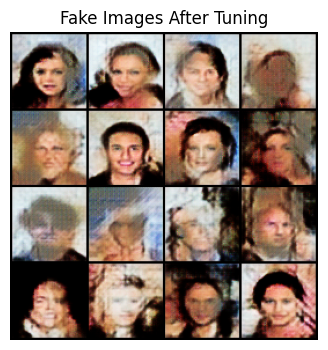

In [80]:
n_eval_samples = 2500
z = torch.randn(n_eval_samples, best_latent_dim, 1, 1, device=device)
fake_images = generator(z).detach()
real_images = next(iter(train_loader))[0][:n_eval_samples].to(device)

fake_grid = torchvision.utils.make_grid(fake_images[:16], nrow=4, normalize=True)
plt.figure(figsize=(4, 4))
plt.imshow(np.transpose(fake_grid.cpu().numpy(), (1, 2, 0)))
plt.title("Fake Images After Tuning")
plt.axis("off")
plt.show()

In [81]:
is_mean, is_std = get_inception_score(fake_images, splits=10)
fid_value = compute_fid(real_images, fake_images)

print(f"After tuning - IS: {is_mean:.2f} ± {is_std:.2f} , FID: {fid_value:.2f}")

After tuning - IS: 3.26 ± 0.20 , FID: 983.53


# Part 4: Train a Classifier on Real Data

In [54]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [55]:
model = CNNClassifier().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 30
batch_size = 128
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels, _) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.float().view(-1, 1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Batch {i}/{len(train_loader)}, Train Loss: {loss.item():.4f}")

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels, _ in val_loader:
            images = images.to(device)
            labels = labels.float().view(-1, 1).to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (outputs >= 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Epoch 1/30, Batch 0/377, Train Loss: 0.7062
Epoch 1/30, Batch 100/377, Train Loss: 0.5035
Epoch 1/30, Batch 200/377, Train Loss: 0.5430
Epoch 1/30, Batch 300/377, Train Loss: 0.4679
Epoch 1/30, Train Loss: 0.4587, Val Loss: 0.4062, Val Accuracy: 82.96%
Epoch 2/30, Batch 0/377, Train Loss: 0.4822
Epoch 2/30, Batch 100/377, Train Loss: 0.4927
Epoch 2/30, Batch 200/377, Train Loss: 0.3946
Epoch 2/30, Batch 300/377, Train Loss: 0.3436
Epoch 2/30, Train Loss: 0.3920, Val Loss: 0.4038, Val Accuracy: 82.83%
Epoch 3/30, Batch 0/377, Train Loss: 0.3880
Epoch 3/30, Batch 100/377, Train Loss: 0.2574
Epoch 3/30, Batch 200/377, Train Loss: 0.5105
Epoch 3/30, Batch 300/377, Train Loss: 0.2520
Epoch 3/30, Train Loss: 0.3629, Val Loss: 0.3658, Val Accuracy: 84.46%
Epoch 4/30, Batch 0/377, Train Loss: 0.2622
Epoch 4/30, Batch 100/377, Train Loss: 0.2866
Epoch 4/30, Batch 200/377, Train Loss: 0.3428
Epoch 4/30, Batch 300/377, Train Loss: 0.2980
Epoch 4/30, Train Loss: 0.3390, Val Loss: 0.3665, Val Accur

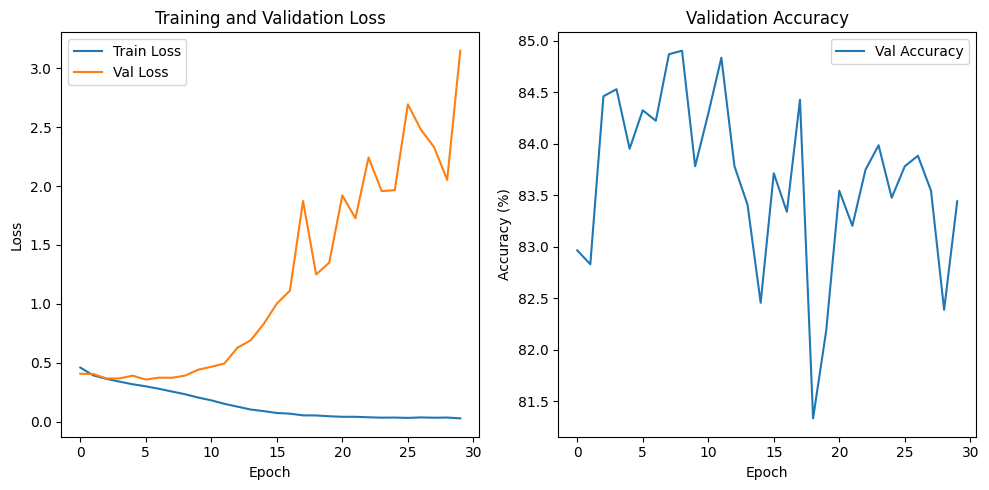

In [56]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Validation Accuracy")
plt.tight_layout()
plt.show()

In [57]:
torch.save(model.state_dict(), "cnn_classifier_real_data.pth")
print("Model saved as cnn_classifier_real_data.pth")

Model saved as cnn_classifier_real_data.pth


In [58]:
classifier = CNNClassifier().to(device)
classifier.load_state_dict(torch.load("cnn_classifier_real_data.pth"))
classifier.eval()

y_true = []
y_pred = []
with torch.no_grad():
    for images, labels, _ in test_loader:
        images = images.to(device)
        labels = labels.float().view(-1, 1).to(device)
        outputs = classifier(images)
        predicted = (outputs >= 0.5).float()
        y_true.extend(labels.cpu().numpy().flatten())
        y_pred.extend(predicted.cpu().numpy().flatten())

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Test Set Metrics (Real Data Only):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

/tmp/ipykernel_31/3843657038.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load("cnn_classifier_real_data.pth"))


Test Set Metrics (Real Data Only):
Accuracy: 0.8380
Precision: 0.8504
Recall: 0.9524
F1-Score: 0.8985


# Part 5: Annotate Synthetic Data

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

classifier = CNNClassifier().to(device)
classifier.load_state_dict(torch.load("cnn_classifier_real_data.pth"))
classifier.eval()

best_latent_dim = 64
num_synthetic = int(len(train_dataset) * 0.7)
print(f"Generating {num_synthetic} synthetic images...")

generator.eval()
synthetic_images = []
synthetic_labels = []
batch_size = 128

with torch.no_grad():
    for i in range(0, num_synthetic, batch_size):
        curr_batch_size = min(batch_size, num_synthetic - i)
        z = torch.randn(curr_batch_size, best_latent_dim, 1, 1, device=device)
        fake_imgs = generator(z)

        outputs = classifier(fake_imgs)
        predicted = (outputs >= 0.5).float()

        synthetic_images.append(fake_imgs.cpu())
        synthetic_labels.append(predicted.cpu())

        if i % 1000 == 0:
            print(f"Generated and annotated {i} images...")

synthetic_images = torch.cat(synthetic_images, dim=0)
synthetic_labels = torch.cat(synthetic_labels, dim=0)
print(f"Total synthetic images generated: {len(synthetic_images)}")

/tmp/ipykernel_31/2231121892.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load("cnn_classifier_real_data.pth"))


Generating 16871 synthetic images...
Generated and annotated 0 images...
Generated and annotated 16000 images...
Total synthetic images generated: 16871


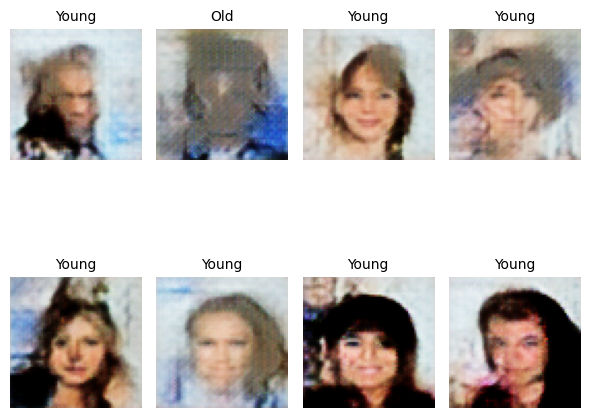

In [62]:
def show_images_with_labels(images, labels, nrow=4, figsize=(6, 6)):
    # Denormalize (from [-1,1] to [0,1])
    images = images / 2 + 0.5
    images = images.cpu().numpy()
    labels = labels.cpu().numpy().flatten()

    n_images = len(images)
    ncol = nrow
    nrow = (n_images + ncol - 1) // ncol

    fig, axs = plt.subplots(nrow, ncol, figsize=figsize)
    axs = axs.flatten()

    for i in range(len(images)):
        img = np.transpose(images[i], (1, 2, 0))
        axs[i].imshow(img)
        axs[i].set_title("Young" if labels[i] == 1 else "Old", fontsize=10)
        axs[i].axis('off')

    # Turn off extra axes if not full grid
    for j in range(len(images), len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

# Usage
show_images_with_labels(synthetic_images[:8], synthetic_labels[:8])

# Part 6: Training a Classifier on Real Data + Synthetic Data

In [65]:
synthetic_images = torch.load("synthetic_images.pt")
synthetic_labels = torch.load("synthetic_labels.pt")

print(f"Loaded {len(synthetic_images)} synthetic images with labels")

synthetic_dataset = torch.utils.data.TensorDataset(synthetic_images, synthetic_labels)

num_real = int(0.7 * len(train_dataset))
real_indices = torch.randperm(len(train_dataset))[:num_real]
real_subset = torch.utils.data.Subset(train_dataset, real_indices)

real_images_labels = [real_subset[i] for i in range(len(real_subset))]
real_images = torch.stack([item[0] for item in real_images_labels])
real_labels = torch.tensor([item[1] for item in real_images_labels], dtype=torch.float32).view(-1, 1)

real_dataset = torch.utils.data.TensorDataset(real_images, real_labels)

combined_dataset = torch.utils.data.ConcatDataset([synthetic_dataset, real_dataset])
print(f"Combined dataset size: {len(combined_dataset)} (Synthetic: {len(synthetic_dataset)}, Real: {len(real_dataset)})")

/tmp/ipykernel_31/816246960.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  synthetic_images = torch.load("synthetic_images.pt")
/tmp/ipykernel_31/816246960.py:2: Future

Loaded 16871 synthetic images with labels
Combined dataset size: 33742 (Synthetic: 16871, Real: 16871)


In [66]:
batch_size = 128
combined_loader = torch.utils.data.DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

model = CNNClassifier().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 30
train_losses = []

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(combined_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Batch {i}/{len(combined_loader)}, Train Loss: {loss.item():.4f}")

    train_loss = running_loss / len(combined_loader)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}/{n_epochs}, Avg Train Loss: {train_loss:.4f}")

Epoch 1/30, Batch 0/264, Train Loss: 0.7060
Epoch 1/30, Batch 100/264, Train Loss: 0.5119
Epoch 1/30, Batch 200/264, Train Loss: 0.4259
Epoch 1/30, Avg Train Loss: 0.4373
Epoch 2/30, Batch 0/264, Train Loss: 0.4675
Epoch 2/30, Batch 100/264, Train Loss: 0.3223
Epoch 2/30, Batch 200/264, Train Loss: 0.2959
Epoch 2/30, Avg Train Loss: 0.3799
Epoch 3/30, Batch 0/264, Train Loss: 0.2690
Epoch 3/30, Batch 100/264, Train Loss: 0.3523
Epoch 3/30, Batch 200/264, Train Loss: 0.3121
Epoch 3/30, Avg Train Loss: 0.3552
Epoch 4/30, Batch 0/264, Train Loss: 0.4928
Epoch 4/30, Batch 100/264, Train Loss: 0.2519
Epoch 4/30, Batch 200/264, Train Loss: 0.3813
Epoch 4/30, Avg Train Loss: 0.3355
Epoch 5/30, Batch 0/264, Train Loss: 0.4795
Epoch 5/30, Batch 100/264, Train Loss: 0.3051
Epoch 5/30, Batch 200/264, Train Loss: 0.2084
Epoch 5/30, Avg Train Loss: 0.3164
Epoch 6/30, Batch 0/264, Train Loss: 0.3266
Epoch 6/30, Batch 100/264, Train Loss: 0.3017
Epoch 6/30, Batch 200/264, Train Loss: 0.3120
Epoch 6/3

In [67]:
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels, _ in test_loader:
        images = images.to(device)
        labels = labels.float().view(-1, 1).to(device)
        outputs = model(images)
        predicted = (outputs >= 0.5).float()
        y_true.extend(labels.cpu().numpy().flatten())
        y_pred.extend(predicted.cpu().numpy().flatten())

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Test Set Metrics (Real Data + Synthetic Data):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Test Set Metrics (Real Data + Synthetic Data):
Accuracy: 0.8157
Precision: 0.8564
Recall: 0.9075
F1-Score: 0.8812
